In [2]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import pandas as pd
import time
from sklearn.metrics import f1_score


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")

# Load data

In [4]:
df = pd.read_csv('train_2024.csv')
df.head()

,id,text,label
0,0,Except that Desmond played first base last nig...,0
1,1,What i find funny is the loyalty and blindness...,0
2,2,Read the article not just the headline & you ...,0
3,3,Speaking of a horses backside is that where y...,1
4,4,Michael Barone- gee are you dumb. No other wo...,1


In [5]:
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import unicodedata
import re
import spacy

EOS_token = 1
lemmatizer = spacy.load("en_core_web_sm")

class TranslationDataset(Dataset):
	def __init__(self, csv_path, dataset_type='train', vocab=None):
		df = pd.read_csv(csv_path, quoting=3)
		print(f'len df: {len(df)}')
		if dataset_type in ['train', 'val']:
			self.text, self.labels = zip(*[(text, label) for text, label in zip(df['text'], df['label'])])
		else:
			self.text = df['text'].tolist()
			self.labels = [0 for _ in range(len(self.text))]
		self.ids = df['id'].tolist()
		self.dataset_type = dataset_type
		self.tokenizer = get_tokenizer('basic_english')
		self._preprocess(vocab)

	def _preprocess(self, vocab):
		# preprocess text
		self.text = [self._preprocess_sentence(text) for text in self.text]

		if vocab is None:
			self.vocab = build_vocab_from_iterator(self._yield_tokens(), specials=["<unk>"])
			self.vocab.set_default_index(self.vocab['<unk>'])
			self.vocab.insert_token('<eos>', EOS_token)  # Insert <eos> token with index 1
		else:
			self.vocab = vocab
			
		self.vocab_size = len(self.vocab)
	
	def _preprocess_sentence(self, sentence):
		sentence = normalizeString(sentence)
		sentence = self.tokenizer(sentence)
		sentence = lemmaString(sentence)
		return sentence

	def _yield_tokens(self):
		for text_sample in self.text:
			yield text_sample

	def __len__(self):
		return len(self.text)

	def __getitem__(self, idx):
		input_seq = text_to_indices(self.vocab, self.text[idx])
		label = self.labels[idx]
		return input_seq, label, self.ids[idx]

def unicodeToAscii(s):
	return ''.join(
		c for c in unicodedata.normalize('NFD', s)
		if unicodedata.category(c) != 'Mn'
	)

def normalizeString(s):
	s = unicodeToAscii(s.lower().strip())
	s = re.sub(r"([.!?])", r" \1", s)
	s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
	return s

def lemmaString(tokens):
	return [token.lemma_ for token in lemmatizer(' '.join(tokens))]

def text_to_indices(vocab, tokens):
	indices = [vocab[token] for token in tokens]
	indices.append(EOS_token)
	return torch.tensor(indices, dtype=torch.long).view(-1)

def seq_to_tokens(seq, vocab):
    itos = vocab.get_itos()
    return [itos[idx] for idx in seq]

In [6]:
trainset = TranslationDataset('tmp.csv')

len df: 10


In [7]:
src_sentence, label, id_ = trainset[0]
print(seq_to_tokens(src_sentence, trainset.vocab))
print(src_sentence, label)
print(type(src_sentence), type(label))

['except', 'that', 'desmond', 'play', 'first', 'base', 'last', 'night', '.', 'tapia', 'be', 'in', 'lf', 'and', 'reynolds', 'have', 'a', 'night', 'off', '.', '<eos>']
tensor([109,  18,  95, 157, 110,  78, 128,  44,   2, 189,   3,  17, 130,   7,
        172,  16,  25,  44, 145,   2,   1]) 0
<class 'torch.Tensor'> <class 'int'>


# DataLoader

In [8]:
PADDING_VALUE = 0

In [69]:
from torch.nn.utils.rnn import pad_sequence

def collate(list_of_samples):
	"""Merges a list of samples to form a mini-batch.

	Args:
	list_of_samples is a list of tuples (src_seq, tgt_label, id):
		src_seq is of shape (src_seq_length,)
		tgt_label is of shape (1,)
		id is an int

	Returns:
	src_seqs of shape (max_src_seq_length, batch_size): Tensor of padded source sequences.
		The sequences should be sorted by length in a decreasing order, that is src_seqs[:,0] should be
		the longest sequence, and src_seqs[:,-1] should be the shortest.
	src_seq_lengths: List of lengths of source sequences.
	tgt_labels of shape (batch_size, 1): Tensor of labels for each sequence.
	"""
	# YOUR CODE HERE
	src_seqs = [s[0] for s in list_of_samples]
	tgt_labels = torch.LongTensor([s[1] for s in list_of_samples])
	src_seq_lengths = [len(s) for s in src_seqs]
	ids = [s[2] for s in list_of_samples]
	src_seqs = pad_sequence(src_seqs, padding_value=PADDING_VALUE)

	src_seq_lengths, indices = torch.sort(torch.tensor(src_seq_lengths), descending=True)
	src_seqs = src_seqs[:, indices]
	tgt_labels = tgt_labels[indices]
	ids = [ids[i] for i in indices]

	return src_seqs, src_seq_lengths.tolist(), tgt_labels, ids


In [10]:
def test_collate_shapes():
    pairs = [
        (torch.LongTensor([1, 2]), 1, 0),
        (torch.LongTensor([6, 7, 8]), 0, 1),
    ]
    pad_src_seqs, src_seq_lengths, pad_tgt_seqs, ids = collate(pairs)
    assert type(src_seq_lengths) == list, "src_seq_lengths should be a list."
    assert pad_src_seqs.shape == torch.Size([3, 2]), f"Bad pad_src_seqs.shape: {pad_src_seqs.shape}"
    assert pad_src_seqs.dtype == torch.long
    assert pad_tgt_seqs.shape == torch.Size([2]), f"Bad pad_tgt_seqs.shape: {pad_tgt_seqs.shape}"
    assert pad_tgt_seqs.dtype == torch.long
    print('Success')

test_collate_shapes()

Success


In [11]:
# This cell tests collate() function

def test_collate_fn():
    pairs = [
        (torch.tensor([1, 2]), 0, 0),
        (torch.tensor([6, 7, 8]), 1, 1),
        (torch.tensor([11, 12, 13, 14]), 0, 2),
    ]
    pad_src_seqs, src_seq_lengths, pad_tgt_seqs, ids = collate(pairs)
    assert pad_src_seqs.shape == torch.Size([4, 3]), f"Bad pad_src_seqs.shape: {pad_src_seqs.shape}"
    assert pad_tgt_seqs.shape == torch.Size([3]), f"Bad pad_tgt_seqs.shape: {pad_tgt_seqs.shape}"
    print('Source sequences combined:')
    print(pad_src_seqs)
    expected = torch.tensor([
      [11, 6, 1],
      [12, 7, 2],
      [13, 8, 0],
      [14, 0, 0],
    ])
    assert (pad_src_seqs == expected).all(), "pad_src_seqs does not match expected values"

    print(src_seq_lengths)
    if isinstance(src_seq_lengths[0], torch.Size):
        src_seq_lengths = sum((list(l) for l in src_seq_lengths), [])
    else:
        src_seq_lengths = [int(l) for l in src_seq_lengths]
    assert src_seq_lengths == [4, 3, 2], f"Bad src_seq_lengths: {src_seq_lengths}"

    print('Target sequences combined:')
    print(pad_tgt_seqs)
    expected = torch.tensor([
      0, 1, 0
    ])
    assert (pad_tgt_seqs == expected).all(), "pad_tgt_seqs0 does not match expected values"
    print('Success')

test_collate_fn()


Source sequences combined:
tensor([[11,  6,  1],
        [12,  7,  2],
        [13,  8,  0],
        [14,  0,  0]])
[4, 3, 2]
Target sequences combined:
tensor([0, 1, 0])
Success


In [12]:
# # We create custom DataLoader using the implemented collate function
# # We are going to process 64 sequences at the same time (batch_size=64)
# trainset = TranslationDataset('train_2024.csv')
# trainloader = DataLoader(dataset=trainset, batch_size=640, shuffle=False, collate_fn=collate, pin_memory=True)

In [13]:
# # Test data loader
# for i, (src_seqs, src_seq_lengths, tgt_seqs, ids) in enumerate(trainloader):
#     print(f"Batch {i} src_seqs:")
#     print(src_seqs)
#     print(f'src_seqs.shape: {src_seqs.shape}')
#     print(f"Batch {i} src_seq_lengths:")
#     print(src_seq_lengths)
#     print(f"Batch {i} tgt_seqs:")
#     print(tgt_seqs)
#     print(f'tgt_seqs.shape: {tgt_seqs.shape}')
#     break

# LSTM

In [14]:
class LSTM(nn.Module):
	def __init__(self, src_dictionary_size, embed_size, hidden_size, dropout=0.2, glove_embeddings=None):
		"""
		Args:
		src_dictionary_size: The number of words in the source dictionary.
		embed_size: The number of dimensions in the word embeddings.
		hidden_size: The number of features in the hidden state of GRU.
		"""
		super(LSTM, self).__init__()
		self.hidden_size = hidden_size
		self.embedding = nn.Embedding(src_dictionary_size, embed_size)
		if glove_embeddings is not None:
			self.load_glove_embeddings(glove_embeddings, embed_size)
	
		self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=1, batch_first=False, dropout=dropout, bidirectional=False)
		self.fc1 = nn.Linear(hidden_size, 128)
		self.fc2 = nn.Linear(128, 1)
		self.relu = nn.ReLU()
		self.sigmoid = nn.Sigmoid()
		self.dropout = nn.Dropout(dropout)
	
	def load_glove_embeddings(self, glove_embeddings, embed_size):
		"""Initialize the embedding layer with GloVe embeddings."""
		weights_matrix = torch.zeros((self.embedding.num_embeddings, embed_size))

		for i, word in enumerate(glove_embeddings):
			try:
				weights_matrix[i] = torch.FloatTensor(glove_embeddings[word])
			except Exception as e:
				print(e)
				print(torch.FloatTensor(glove_embeddings[word]).size())
				print(f'word: {word}, i: {i}')

		self.embedding.load_state_dict({'weight': weights_matrix})

	def forward(self, pad_seqs, seq_lengths, hidden):
		"""
		Args:
		pad_seqs of shape (max_seq_length, batch_size): Padded source sequences.
		seq_lengths: List of sequence lengths.
		hidden of shape (1, batch_size, hidden_size): Initial states of the GRU.

		Returns:
		outputs of shape (max_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
		hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
		"""
		# YOUR CODE HERE
		embedded = self.embedding(pad_seqs) # shape: (max_seq_length, batch_size, embed_size)
		packed = pack_padded_sequence(embedded, seq_lengths)
		outputs, hidden = self.lstm(packed, hidden) 
		outputs, output_lengths = pad_packed_sequence(outputs, batch_first=False) # shape: (max_seq_length, batch_size, hidden_size)
		last_timesteps = torch.stack([outputs[length-1, i] for i, length in enumerate(output_lengths)]) # shape: (batch_size, hidden_size)
		# feed through the fully connected layer
		outputs = self.fc1(last_timesteps)
		outputs = self.dropout(outputs)
		outputs = self.relu(outputs)
		outputs = self.fc2(outputs)
		outputs = self.sigmoid(outputs)
		return outputs

	def init_hidden(self, batch_size=1, device='cpu'):
		num_directions = 1
		return (
			torch.zeros(self.lstm.num_layers * num_directions, batch_size, self.hidden_size).to(device),
			torch.zeros(self.lstm.num_layers * num_directions, batch_size, self.hidden_size).to(device),
		)

In [15]:
class LSTM_CNN(nn.Module):
    def __init__(self, src_dictionary_size, embed_size, hidden_size, num_filters=100, kernel_sizes= [3, 4, 5], dropout=0.2, glove_embeddings=None):
        """
        Args:
        src_dictionary_size: The number of words in the source dictionary.
        embed_size: The number of dimensions in the word embeddings.
        hidden_size: The number of features in the hidden state of GRU.
        """
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(src_dictionary_size, embed_size)
        if glove_embeddings is not None:
            self.load_glove_embeddings(glove_embeddings, embed_size)

        # CNN layers
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_size, out_channels=num_filters, kernel_size=k, stride=1, padding=k // 2)
            for k in kernel_sizes
        ])
        self.conv_output_size = num_filters * len(kernel_sizes)
    
        # LSTM
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=1, batch_first=False, dropout=dropout, bidirectional=False)
        
        # FC layers
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
    
    def load_glove_embeddings(self, glove_embeddings, embed_size):
        """Initialize the embedding layer with GloVe embeddings."""
        weights_matrix = torch.zeros((self.embedding.num_embeddings, embed_size))

        for i, word in enumerate(glove_embeddings):
            try:
                weights_matrix[i] = torch.FloatTensor(glove_embeddings[word])
            except Exception as e:
                print(e)
                print(torch.FloatTensor(glove_embeddings[word]).size())
                print(f'word: {word}, i: {i}')

        self.embedding.load_state_dict({'weight': weights_matrix})

    def forward(self, pad_seqs, seq_lengths, hidden):
        """
        Args:
        pad_seqs of shape (max_seq_length, batch_size): Padded source sequences.
        seq_lengths: List of sequence lengths.
        hidden of shape (1, batch_size, hidden_size): Initial states of the GRU.

        Returns:
        outputs of shape (max_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
        hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
        """
        # YOUR CODE HERE
        embedded = self.embedding(pad_seqs) # shape: (max_seq_length, batch_size, embed_size)
        
        # reshape before feeding through the CNN layers
        embedded = embedded.permute(1, 2, 0)  # shape: (batch_size, embed_size, max_seq_length)

        # Apply CNN and ReLU activation
        cnn_out = [torch.relu(conv(embedded)) for conv in self.convs]
        cnn_out = torch.cat(cnn_out, 1)  # concatenate along the channel dimension shape: (batch_size, num_filters * len(kernel_sizes), max_seq_length)
        cnn_out = cnn_out.permute(2, 0, 1)  # shape: (max_seq_length, batch_size, conv_output_size)
        embedded = cnn_out

        # feed through the LSTM layer
        packed = pack_padded_sequence(embedded, seq_lengths)
        outputs, hidden = self.lstm(packed, hidden) 
        outputs, output_lengths = pad_packed_sequence(outputs, batch_first=False) # shape: (max_seq_length, batch_size, hidden_size)
        last_timesteps = torch.stack([outputs[length-1, i] for i, length in enumerate(output_lengths)]) # shape: (batch_size, hidden_size)
        # feed through the fully connected layer
        outputs = self.fc1(last_timesteps)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.fc2(outputs)
        outputs = self.sigmoid(outputs)
        return outputs

    def init_hidden(self, batch_size=1, device='cpu'):
        num_directions = 1
        return (
            torch.zeros(self.lstm.num_layers * num_directions, batch_size, self.hidden_size).to(device),
            torch.zeros(self.lstm.num_layers * num_directions, batch_size, self.hidden_size).to(device),
        )

In [16]:
def test_LSTM_shapes():
    hidden_size = 3
    lstm = LSTM(src_dictionary_size=5, embed_size=10, hidden_size=hidden_size)

    max_seq_length = 4
    batch_size = 2
    hidden = lstm.init_hidden(batch_size=batch_size)
    pad_seqs = torch.tensor([
        [        1,             2],
        [        2,     EOS_token],
        [        3, PADDING_VALUE],
        [EOS_token, PADDING_VALUE]
    ])

    outputs = lstm.forward(pad_seqs=pad_seqs, seq_lengths=[4, 2], hidden=hidden)
    assert outputs.shape == torch.Size([batch_size, 1]), f"Bad outputs.shape: {outputs.shape}"
    print('Success')

test_LSTM_shapes()

Success


c:\Users\xuong\.conda\envs\sl\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Training

In [17]:
def val_loss(model, val_loader):
	model.eval()
	total_loss = 0
	criterion = nn.BCELoss()
	with torch.no_grad():
		for i, (src_seqs, src_seq_lengths, tgt_labels, ids) in enumerate(val_loader):
			src_seqs, tgt_labels = src_seqs.to(device), tgt_labels.to(device)
			hidden = model.init_hidden(src_seqs.shape[1], device=device)
			outputs = model(src_seqs, src_seq_lengths, hidden)
			loss = criterion(outputs.squeeze(), tgt_labels.float())
			total_loss += loss.item()
	return total_loss / len(val_loader)

In [70]:
# We create custom DataLoader using the implemented collate function
# We are going to process 640 sequences at the same time (batch_size=640)
# load vocab
# vocab = torch.load('vocab.pth')
# vocab = None
# trainset = TranslationDataset('train_2024.csv', vocab=vocab)
trainset = torch.load('dataloaders/trainset.pth')
print(len(trainset.text))
trainloader = DataLoader(dataset=trainset, batch_size=640, shuffle=False, collate_fn=collate, pin_memory=True)

99000


In [71]:
# We create custom DataLoader using the implemented collate function
# We are going to process 64 sequences at the same time (batch_size=64)
# valset = TranslationDataset('dev_2024.csv', vocab=trainset.vocab)
valset = torch.load('dataloaders/valset.pth')
print(len(valset.text))
valloader = DataLoader(dataset=valset, batch_size=256, shuffle=False, collate_fn=collate, pin_memory=True)

11000


In [20]:
# save trainset
# torch.save(trainset, 'trainset.pth')

# save valset
# torch.save(valset, 'valset.pth')

In [21]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.
        
        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).
                 
                 Otherwise, False.
        """
        if len(val_errors) <= self.patience:
            return False

        min_val_error = min(val_errors)
        val_errors = np.array(val_errors[-self.patience:])
        return all(val_errors > min_val_error + self.tolerance)

early_stop = EarlyStopping(tolerance=0.001, patience=5)

## Vanilla LSTM

In [26]:
# Create the LSTM model
hidden_size = embed_size = 256
lstm = LSTM(trainset.vocab_size, embed_size, hidden_size).to(device)

# Load pretrained LSTM
# lstm.load_state_dict(torch.load('lstm_best.pth'))

c:\Users\xuong\.conda\envs\sl\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [77]:
# training
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)

n_epochs = 20
# prompt ask for continue training or not
cont = input('Continue training? yes or no')
if cont == 'no':
	print('Fresh training')
	train_losses = []
	val_losses = []
	best_model = None
	best_val_loss = float('inf')
else:
	print(f'Continue training')
	
for epoch in range(n_epochs):
	lstm.train()
	running_loss = 0.0
	epoch_start_time = time.time()
	print(f'Number of batches: {len(trainloader)}')
	print(f'batch_size: {trainloader.batch_size}')
	for i, (src_seqs, src_seq_lengths, tgt_labels, ids) in enumerate(trainloader):
		start_time = time.time()
		src_seqs, tgt_labels = src_seqs.to(device), tgt_labels.to(device)
		hidden = lstm.init_hidden(src_seqs.shape[1], device=device)
		optimizer.zero_grad()
		outputs = lstm(src_seqs, src_seq_lengths, hidden)
		loss = criterion(outputs.squeeze(), tgt_labels.float())
		loss.backward()
		optimizer.step()
		running_loss += loss.item()
		if i % 10 == 9:
			print(f'Epoch {epoch + 1}, iter {i + 1}: avg. loss = {running_loss/(i + 1):.4f}, Time spent: {time.time()-start_time:.2f}s')
	train_losses.append(running_loss / len(trainloader))
	eval_loss = val_loss(lstm, valloader)
	if eval_loss < best_val_loss:
		best_val_loss = eval_loss
		best_model = lstm.state_dict()
		if best_model is not None:
			print(f'find new best model, save to lstm.pth, eval_loss: {eval_loss:.4f}')
			torch.save(best_model, 'models/lstm.pth')

	if early_stop.stop_criterion(val_losses):
		print(f'Early stopping on epoch {epoch + 1}')
		break
	
	val_losses.append(eval_loss)
	print(f'Epoch {epoch + 1}, val loss = {eval_loss:.4f}, train loss = {train_losses[-1]:.4f}; Time spent: {time.time()-epoch_start_time:.2f}s')
	running_loss = 0.0

Continue training
Number of batches: 155
batch_size: 640
Epoch 1, iter 10: avg. loss = 0.2052, Time spent: 4.75s
Epoch 1, iter 20: avg. loss = 0.2008, Time spent: 5.09s
Epoch 1, iter 30: avg. loss = 0.1968, Time spent: 8.31s
Epoch 1, iter 40: avg. loss = 0.1959, Time spent: 5.94s
Epoch 1, iter 50: avg. loss = 0.1912, Time spent: 5.70s
Epoch 1, iter 60: avg. loss = 0.1879, Time spent: 5.42s
Epoch 1, iter 70: avg. loss = 0.1865, Time spent: 5.26s
Epoch 1, iter 80: avg. loss = 0.1839, Time spent: 5.56s
Epoch 1, iter 90: avg. loss = 0.1822, Time spent: 10.76s
Epoch 1, iter 100: avg. loss = 0.1820, Time spent: 5.45s
Epoch 1, iter 110: avg. loss = 0.1828, Time spent: 5.78s
Epoch 1, iter 120: avg. loss = 0.1833, Time spent: 5.45s
Epoch 1, iter 130: avg. loss = 0.1823, Time spent: 6.67s
Epoch 1, iter 140: avg. loss = 0.1820, Time spent: 4.60s
Epoch 1, iter 150: avg. loss = 0.1830, Time spent: 4.72s
find new best model, save to lstm.pth, eval_loss: 0.2162
Epoch 1, val loss = 0.2162, train loss 

In [34]:
# Save model and vocab
torch.save(lstm.state_dict(), 'lstm.pth')
torch.save(trainset.vocab, 'vocab.pth')

# # Load model
# lstm = LSTM(trainset.vocab_size, embed_size, hidden_size).to(device)
# lstm.load_state_dict(torch.load('lstm.pth'))

## GloVe + LSTM

In [44]:
# Assume you have a function to load GloVe embeddings
def load_glove_embeddings(filepath):
    glove_embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings

# Load GloVe embeddings from a file
glove_embeddings = load_glove_embeddings('glove_embeddings/glove.twitter.27B.100d.txt')

# Create a dictionary with your src_dictionary and GloVe embeddings
src_dictionary = trainset.vocab  # Add your vocabulary here
src_dictionary_size = len(src_dictionary)
embed_size = 100  # Example embedding size

# Map GloVe vectors to your src_dictionary index
mapped_glove_embeddings = {}
for word, index in src_dictionary.get_stoi().items():
    if word in glove_embeddings:
        mapped_glove_embeddings[index] = glove_embeddings[word]
    else:
        # If word is not in GloVe, initialize a random vector
        mapped_glove_embeddings[index] = np.random.normal(scale=0.6, size=(embed_size,))

In [45]:
# save and load mapped_glove_embeddings
# print('save mapped_glove_embeddings')
# torch.save(mapped_glove_embeddings, 'models/mapped_glove_embeddings.pth')
print('load mapped_glove_embeddings')
mapped_glove_embeddings = torch.load('models/mapped_glove_embeddings.pth')

save mapped_glove_embeddings
load mapped_glove_embeddings


In [46]:
hidden_size = 256
embed_size = 100
lstm_glove = LSTM(trainset.vocab_size, embed_size, hidden_size, dropout=0.2, glove_embeddings=mapped_glove_embeddings).to(device)

c:\Users\xuong\.conda\envs\sl\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [76]:
# training
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_glove.parameters(), lr=0.001, weight_decay=1e-5)

n_epochs = 40
# prompt ask for continue training or not
cont = input('Continue training? yes or no')
if cont == 'no':
	print('Fresh training')
	train_losses = []
	val_losses = []
	best_model = None
	best_val_loss = float('inf')
else:
	print(f'Continue training')

for epoch in range(n_epochs):
	lstm_glove.train()
	running_loss = 0.0
	epoch_start_time = time.time()
	print(f'Number of batches: {len(trainloader)}')
	print(f'batch_size: {trainloader.batch_size}')
	for i, (src_seqs, src_seq_lengths, tgt_labels, ids) in enumerate(trainloader):
		start_time = time.time()
		src_seqs, tgt_labels = src_seqs.to(device), tgt_labels.to(device)
		hidden = lstm_glove.init_hidden(src_seqs.shape[1], device=device)
		optimizer.zero_grad()
		outputs = lstm_glove(src_seqs, src_seq_lengths, hidden)
		loss = criterion(outputs.squeeze(), tgt_labels.float())
		loss.backward()
		optimizer.step()
		running_loss += loss.item()
		if i % 10 == 9:
			print(f'Epoch {epoch + 1}, iter {i + 1}: avg. loss = {running_loss/(i + 1):.4f}, Time spent: {time.time()-start_time:.2f}s')
	train_losses.append(running_loss / len(trainloader))
	eval_loss = val_loss(lstm_glove, valloader)

	if eval_loss < best_val_loss:
		best_val_loss = eval_loss
		best_model = lstm_glove.state_dict()
		if best_model is not None:
			print(f'find new best model, save to models/lstm_glove.pth, eval_loss: {eval_loss:.4f}')
			torch.save(best_model, os.path.join('models', 'lstm_glove.pth'))

	# if early_stop.stop_criterion(val_losses):
	# 	print(f'Early stopping at epoch {epoch + 1}')
	# 	break
	
	val_losses.append(eval_loss)
	print(f'Epoch {epoch + 1}, val loss = {eval_loss:.4f}, train loss = {train_losses[-1]:.4f}; Time spent: {time.time()-epoch_start_time:.2f}s')
	running_loss = 0.0

NameError: name 'lstm_glove' is not defined

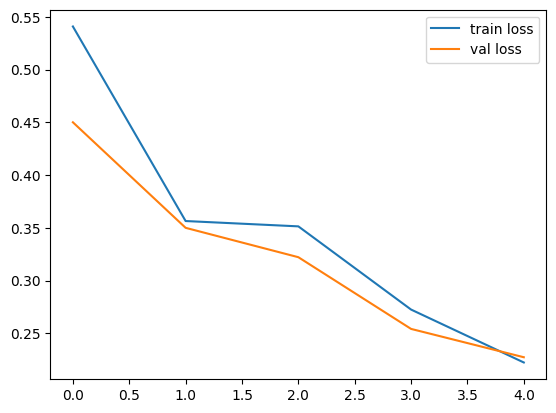

In [75]:
# plot learning curve
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

# Inference

## Choose model to load

In [23]:
# vanilla LSTM
# hidden_size = embed_size = 256
# lstm = LSTM(trainset.vocab_size, embed_size, hidden_size).to(device)
# lstm.load_state_dict(torch.load('lstm.pth'))

# LSTM with GloVe embeddings
hidden_size = 256
embed_size = 100
lstm_glove = LSTM(trainset.vocab_size, embed_size, hidden_size, dropout=0.2, glove_embeddings=None).to(device)
lstm_glove.load_state_dict(torch.load('models/lstm_glove.pth'))

c:\Users\xuong\.conda\envs\sl\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [24]:
def classify(lstm, pad_src_seqs, src_seq_lengths):
    """Translate sequences from the source language to the target language using the trained model.

    Args:
    lstm (LSTM): Trained lstm.
    pad_src_seqs of shape (max_src_seq_length, batch_size): Padded source sequences.
    src_seq_lengths: List of source sequence lengths.

    Returns:
    out_seqs of shape (batch_size, 1): LongTensor of word indices of the output sequences.
    """
    # YOUR CODE HERE
    with torch.no_grad():
        pad_src_seqs = pad_src_seqs.to(device)
        lstm_hidden = lstm.init_hidden(pad_src_seqs.shape[1], device)
        outputs = lstm(pad_src_seqs, src_seq_lengths, lstm_hidden)
        out_seqs = outputs > 0.5
        return out_seqs

In [72]:
def test_translate_shapes(lstm):
    pad_src_seqs = torch.tensor([
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 0]
    ])

    out_seqs = classify(lstm, pad_src_seqs, src_seq_lengths=[4, 2])
    assert out_seqs.shape == torch.Size([2, 1]), f"Wrong out_seqs.shape: {out_seqs.shape}"
    print('Success')

test_translate_shapes(lstm_glove)

Success


In [25]:
# Translate a few sentences from the training set
print('Classify training data:')
print('-----------------------------')
pad_src_seqs, src_seq_lengths, pad_tgt_seqs, ids = next(iter(valloader))
out_seqs = classify(lstm_glove, pad_src_seqs, src_seq_lengths)

for i in range(5):
    print('SRC:', seq_to_tokens(pad_src_seqs[:,i], trainset.vocab))
    print('TGT:', pad_tgt_seqs[i].item())
    print('OUT:', out_seqs[i].item())
    print('')

Classify training data:
-----------------------------
SRC: ['the', 'benign', 'effect', 'of', 'the', 'financial', 'crisis', 'in', 'canada', 'that', 'reduce', 'consumer', 'borrowing', 'in', 'the', 'us', 'increase', 'it', 'here', '.', 'low', 'rate', 'but', 'a', 'healthy', 'gap', 'between', 'funding', 'level', 'for', 'bank', 'and', 'prime', 'rate', 'mean', 'huge', 'profit', 'form', 'retail', '.', 'the', 'bank', 'push', 'we', 'all', 'to', 'borrow', 'with', 'slogan', 'like', 'you', 'be', 'wealthy', 'than', 'you', 'think', '.', 'I', 'once', 'hear', 'a', 'bank', 'treasurer', 'imply', 'these', 'spread', 'represent', 'over', 'of', 'their', 'profit', 'the', 'prior', 'year', '.', 'and', 'so', 'it', 'be', 'ironic', 'that', 'the', 'bank', 'be', 'now', 'among', 'those', 'heed', 'the', 'debt', 'level', 'warning', '.', 'there', 'can', 'be', 'no', 'explanation', 'other', 'than', 'that', 'they', 'can', 'not', 'wean', 'themselves', 'off', 'it', 'and', 'need', 'osfi', 'to', 'help', '.', 'it', 'be', 'game',

In [26]:
def test_accuracy(lstm, dataloader=valloader):
    correct = 0
    total = 0
    for i, (src_seqs, src_seq_lengths, tgt_labels, ids) in enumerate(dataloader):
        out_seqs = classify(lstm, src_seqs, src_seq_lengths)
        correct += (out_seqs.squeeze().cpu().long() == tgt_labels).sum().item()
        total += tgt_labels.shape[0]
    accuracy = correct / total
    return accuracy

def test_f1_score(lstm, dataloader=valloader):
    y_true = []
    y_pred = []
    for i, (src_seqs, src_seq_lengths, tgt_labels, ids) in enumerate(dataloader):
        out_seqs = classify(lstm, src_seqs, src_seq_lengths)
        y_true.extend(tgt_labels.cpu().numpy())
        y_pred.extend(out_seqs.squeeze().cpu().numpy())
    return f1_score(y_true, y_pred)

In [27]:
# print(test_accuracy(lstm_glove, valloader))
print(test_f1_score(lstm_glove, valloader))

0.9065940863540765


# Inference

In [28]:
# testset = TranslationDataset('test_2024.csv', vocab=trainset.vocab, dataset_type='test')
# testloader = DataLoader(dataset=testset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=True)
# # save testset
# torch.save(testset, 'testset.pth')    

# load testset
testset = torch.load('dataloaders/testset.pth')
testloader = DataLoader(dataset=testset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=True)


In [73]:
# do inference on test set and save the results into csv file
def test_inference(lstm, output_filename='submission.csv', testset=testset):
    testloader = DataLoader(dataset=testset, batch_size=32, shuffle=False, collate_fn=collate, pin_memory=True)
    out = []
    indices = []
    for i, (src_seqs, src_seq_lengths, tgt_labels, ids) in enumerate(testloader):
        out_seqs = classify(lstm, src_seqs, src_seq_lengths)
        try:
            out.extend(out_seqs.squeeze().cpu().numpy())
        except:
            out.append(out_seqs.squeeze().cpu().numpy())
        indices.extend(ids)
    df = pd.DataFrame({'id': indices, 'label': out})
    # convert label to int
    df['label'] = df['label'].astype(int)
    # sort by id
    df = df.sort_values(by='id')
    df.to_csv(output_filename, index=False)
    return df

test_inference(lstm_glove, output_filename='dev_inference.csv', testset=valset)
# test_inference(lstm_glove, output_filename='submission.csv', testset=testset)

,id,label
25,0,0
0,1,0
11,2,0
20,3,1
16,4,0
...,...,...
10990,10995,0
10985,10996,0
10998,10997,1
10983,10998,1


In [74]:
# import precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute Precision, Recall, and F1 Score of the imported predicted csv and the validation df
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

# Load the predicted csv
y_pred = pd.read_csv('dev_inference.csv', index_col=0)
y_pred = y_pred['label'].tolist()

# Load the validation df
y_true = pd.read_csv('dev_2024.csv', quoting=3)
y_true = y_true['label'].tolist()

# Compute the metrics
precision, recall, f1 = compute_metrics(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Precision: 0.9152764640435471
Recall: 0.9100817034496993
F1: 0.9125615068314328
